# Project 3: Topic Modelling with the News content
### Task: 
>> Collect randomly as many as news content from different fields for training. (thru any form, web scrape, pdf, newspaper etc.)

### Data:
>> 1) The datasest values were collected from The Hindu website and the Times Of India website.         
>> 2) Train data was collected from The hindu website on 24 september 2020 at 8:00pm (https://www.thehindu.com/latest-news/),    (https://timesofindia.indiatimes.com/news).  
>> 3) Test data was collected from The hindu website on 25 september 2020 at 7:00 pm (https://www.thehindu.com/latest-news/).  

## Web Scrapping of news

In [1]:
# Importing useful libraries for web scrapping of news...
import pandas as pd
import os
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import ElementClickInterceptedException
from selenium.common.exceptions import StaleElementReferenceException

In [2]:
# Function to scrap Times of India website for news...
news=[]
def TOI():
    url='https://timesofindia.indiatimes.com/news'
    driver=webdriver.Chrome(executable_path='chromedriver')
    driver.get(url)
    for i in range(2,4): # The website contains 3 pages of latest news which refreshes daily
        for j in range(1,20): # Each page have 20 articles
            try:
                driver.implicitly_wait(10) 
                element=driver.find_element_by_xpath(f"//ul[@id='itemContainer']//li[{j}]//span[@class='w_tle']//a").text
            except NoSuchElementException:
                driver.forward()
                element=driver.find_element_by_xpath(f"//ul[@id='itemContainer']//li[{j}]//span[@class='w_tle']//a").text
            driver.implicitly_wait(10)
            driver.find_element_by_link_text(f"{element}").click()
            driver.implicitly_wait(10)
            try:
                p=driver.find_element_by_xpath("//div[@class='ga-headlines']").text
                news.append(p)
                driver.back()
                driver.implicitly_wait(10)
            except NoSuchElementException or ElementClickInterceptedException:
                driver.back()
        driver.find_element_by_xpath(f"//ul[@class='curpgcss']//li[{i}]//a").click()
    print("Scrapping news...")
    print("Web Scrapping of Times of India Website Done..")

In [3]:
# Function to scrap The HINDU website for news...
def HINDU(start,end):
    url='https://www.thehindu.com/latest-news/'
    driver=webdriver.Chrome(executable_path='chromedriver')
    driver.get(url)
    for i in range(start,end):
        driver.implicitly_wait(10)
        try:
            element=driver.find_element_by_xpath(f"//section[@class='container container-mobile ']//div[@class='container']//ul[@class='latest-news']//li[{i}]//a").text
        except NoSuchElementException:
            driver.forward()
            element=driver.find_element_by_xpath(f"//section[@class='container container-mobile ']//div[@class='container']//ul[@class='latest-news']//li[{i}]//a").text
        driver.find_element_by_link_text(f"{element}").click()
        driver.implicitly_wait(10)    
        try:
            p=driver.find_element_by_xpath("//section[@class='container container-mobile article-cont']//div[@class='paywall']").text
            news.append(p) # Appending in the same variable
            driver.back()
            driver.implicitly_wait(10)
        except NoSuchElementException or ElementClickInterceptedException:
            driver.back()
    print("Scrapping news...")
    print("Web Scrapping of The Hindu Website Done..\n")


In [5]:
# Calling functions to scrap the news
print("***************Scrapping Training Data*****************")
print("Scrapping from Times of India")
TOI()
print("Scrapping from The Hindu")
HINDU(1,300)  # the website have around 400 articles on the news daily..


***************Scrapping Training Data*****************
Scrapping from Times of India
Scrapping news...
Web Scrapping of Times of India Website Done..
Scrapping from The Hindu
Scrapping news...
Web Scrapping of The Hindu Website Done..



In [6]:
# Creating a Dataframe of scrapped news
df_train=pd.DataFrame(news,columns=['News'])

# Saving dataframe in a csv file
df_train.to_csv('News_train.csv')

# Printing some samples
df_train.sample(3)

,Unnamed: 0,News
206,206,The National Investigation Agency (NIA) raided...
175,175,NEW DELHI: The three-phase Bihar polls will be...
137,137,"Koo App, a micro blogging platform in a vernac..."


In [7]:
# Now calling function to scrap for the test data
news=[]
print("***************Scrapping Test Data*****************")
print("Scrapping from The Hindu")
HINDU(300,400)

# Creating a Dataframe of scrapped news
df_test=pd.DataFrame(news,columns=['News'])

# Saving dataframe in acsv file
df_test.to_csv('News_test.csv')

# Printing some samples
df_test.sample(3)

***************Scrapping Test Data*****************
Scrapping from The Hindu
Scrapping news...
Web Scrapping of The Hindu Website Done..



,Unnamed: 0,News
3,3,A total of 655 people tested positive for SARS...
2,2,The J&K police on Friday constituted a Special...
0,0,Farmers belonging to associations affiliated t...


**Now because of web scrapping I have the news content now I will do topic modelling based on the data scrapped**

## Topic Modelling

In [8]:
# Importing useful libraries for topic modelling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer, SnowballStemmer

import re
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

In [9]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
# Importing the Scrapped training and testing csv file...
news_train=pd.read_csv("News_train.csv")
news_test=pd.read_csv("News_test.csv")

In [11]:
# checking the features details in the Datasets

print("\nFeatures Present in the Dataset: \n", news_train.columns)
shape=news_train.shape
print("\nTotal Number of Rows : ",shape[0])
print("Total Number of Features : ", shape[1])
print("\n\nData Types of Features :\n", news_train.dtypes)


Features Present in the Dataset: 
 Index(['Unnamed: 0', 'News'], dtype='object')

Total Number of Rows :  300
Total Number of Features :  2


Data Types of Features :
 Unnamed: 0     int64
News          object
dtype: object


In [12]:
# Displaying first few training data...
news_train.head(10)

,Unnamed: 0,News
0,0,Domestic workers staged a dharna in front of t...
1,1,Twelve-time champion Rafael Nadal will open ag...
2,2,"Maharashtra reported 19,164 new COVID-19 cases..."
3,3,"Sabbani Janakiramulu, an oustee of Mamidyala v..."
4,4,The Central Bureau of Investigation has regist...
5,5,A 22-year-old youngster from Gundala village i...
6,6,TDP Polit Bureau member and Leader of Oppositi...
7,7,A person accused of child sexual abuse escaped...
8,8,Chief Minister K. Chandrasekhar Rao has asked ...
9,9,The CPI (Maoist) Charla Local Guerrilla Squad ...


In [13]:
# Displaying first few test data...
news_test.head(4)

,Unnamed: 0,News
0,0,Farmers belonging to associations affiliated t...
1,1,The Special NDPS court on Friday reserved its ...
2,2,The J&K police on Friday constituted a Special...
3,3,A total of 655 people tested positive for SARS...


**NOTE: In the above 2 dataframes unnamed column occured while saving the Dataframe, but it is just the indexm, ignore that**

In [14]:
# Now Converting the training data in a list so that it can be cleaned...
docs_train=[]

for i in news_train['News']:
    a=str(i)
    docs_train.append(a)

In [15]:
# Now Converting the test data in a list so that it can be cleaned...
docs_test=[]

for i in news_test['News']:
    a=str(i)
    docs_test.append(a)

In [16]:
# Displaying training data in a list
docs_train[:5]

['Domestic workers staged a dharna in front of the AG’s Office here on Thursday demanding a comprehensive law for better working conditions, compensation to domestic workers who have lost jobs, and implementation of the urban employment scheme.\nThe protest organised under the umbrella of the SEWA-Union was part of a national agitation against the changes brought by the Union government to labour laws.\nInaugurating the protest, Sonia George, general secretary of the SEWA-Union, said the dharna was the first of protests by domestic workers.\nIn a statement here, the SEWA-Union said domestic workers were among the section of workers who had lost their jobs the most. Though they provided an essential service, they were being kept away from the workplace on the grounds of being virus carriers. The labour bills passed by Parliament did not cover domestic workers.\nMs. George said the Code on Social Security did not define private homes as an establishment or define an employer. Till then, 

### Preprocessing the raw text                          
**This involves the following:          
1) Tokenization: Split the text words. Lowercase the words and remove punctuation.               
2) All the numbers, emails, are removed as they are not needed here                       
3) All stopwords are removed.                                 
4) Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.               
5) Words are stemmed — words are reduced to their root form.                  
6) All the special characters are removed.                
7) All the extra whitespaces are removed.**                           


In [17]:
#     Here I have made a function in which all the Data cleaning steps like removing data which is not useful like 
#      webaddress, email adress, mobile numbers,removing punctuations, converting all the documents into lowercase, 
#           using lemmatization and stemming technique, filtering documents using Stopwords,
#      all these type of data preprocessin steps are being perormed with th ehelp of the function defined below.

stemmer = SnowballStemmer("english")

def Processed_data(news):
    news_corpus = []
    for k in range(0, len(news)):
    # Replace email addresses with 'email'
        review=re.sub(r'^.+@[^\.].*\.[a-z]{2,}$',' ', news[k])
        
    # Replace URLs with 'webaddress'
        review=re.sub(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',' ',review)
        
    # Replace money symbols with 'moneysymb'
        review=re.sub(r'£|\$', ' ',review)
        
    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
        review=re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ',review)
    
    # Replace numbers with 'numbr'
        review=re.sub(r'\d+(\.\d+)?', ' ', review)
        
    # getting only words(i.e removing all the special characters)
        review = re.sub(r'[^\w]', ' ', review) 
        
    # getting only words(i.e removing all the" _ ")
        review = re.sub(r'[\_]', ' ', review) 
    
    # getting rid of unwanted characters(i.e remove all the single characters left)
        review=re.sub(r'\s+[a-zA-Z]\s+', ' ', review)
    
    # Removing extra whitespaces
        review=re.sub(r'\s+', ' ', review, flags=re.I)

    #converting all the letters of the review into lowercase
        review = review.lower()

    # splitting every words from the sentences
        review = review.split()
    
    # iterating through each words and checking if they are stopwords or not,
    # if they are stopwords we will not consider them furthermore and if they are not stopwords then, 
    # performing lemmatization operation on that particular word... 
        review = [(WordNetLemmatizer().lemmatize(word,pos='v')) for word in review if not word in set(STOPWORDS)]

    # joining the review again
        news_corpus.append(review)
    return news_corpus

In [18]:
# Calling Processed_data function to clean the training data and storing the result in Clean_data....
Clean_data=Processed_data(docs_train)

In [19]:
# Displaying few Cleaned data values
Clean_data[:3]

[['domestic',
  'workers',
  'stag',
  'dharna',
  'ag',
  'office',
  'thursday',
  'demand',
  'comprehensive',
  'law',
  'better',
  'work',
  'condition',
  'compensation',
  'domestic',
  'workers',
  'lose',
  'job',
  'implementation',
  'urban',
  'employment',
  'scheme',
  'protest',
  'organise',
  'umbrella',
  'sewa',
  'union',
  'national',
  'agitation',
  'change',
  'bring',
  'union',
  'government',
  'labour',
  'laws',
  'inaugurate',
  'protest',
  'sonia',
  'george',
  'general',
  'secretary',
  'sewa',
  'union',
  'say',
  'dharna',
  'protest',
  'domestic',
  'workers',
  'statement',
  'sewa',
  'union',
  'say',
  'domestic',
  'workers',
  'section',
  'workers',
  'lose',
  'job',
  'provide',
  'essential',
  'service',
  'keep',
  'away',
  'workplace',
  'ground',
  'virus',
  'carriers',
  'labour',
  'bill',
  'pass',
  'parliament',
  'cover',
  'domestic',
  'workers',
  'ms',
  'george',
  'say',
  'code',
  'social',
  'security',
  'define',

In [20]:
# Making dictionary data set...
dictionary = gensim.corpora.Dictionary(Clean_data)

In [21]:
# printing dictionary values
print (dictionary)

Dictionary(7416 unique tokens: ['able', 'ag', 'agitation', 'apprehensions', 'argument']...)


In [22]:
#Lets see if dictionary created succesfully
count=0
for k,v in dictionary.iteritems():
    print (k, v)
    count +=1
    if count >20:
        break

0 able
1 ag
2 agitation
3 apprehensions
4 argument
5 away
6 benefit
7 better
8 bill
9 bring
10 carriers
11 change
12 code
13 compensation
14 comprehensive
15 condition
16 cover
17 define
18 demand
19 dharna
20 domestic


In [23]:
# removing rare and repeatative words
dictionary.filter_extremes(no_below=2,no_above=0.2,keep_n=100000)

**Filter out tokens that appear in:             
1) less than 2 documents                 
2) more than 0.2 documents (fraction of total corpus size, not absolute number).                  
3) after the above two steps, keep only the first 100000 most frequent tokens.**               

In [24]:
#Printing dictionary with final values
print (dictionary)

Dictionary(3198 unique tokens: ['able', 'agitation', 'apprehensions', 'argument', 'away']...)


In [25]:
# Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
# words and how many times those words appear. Save this to 'bow_corpus'
bow_corpus = [dictionary.doc2bow(doc) for doc in Clean_data]

In [26]:
# Displaying an example of the bow_corpus
bow_corpus[5]

[(3, 1),
 (59, 1),
 (82, 1),
 (85, 1),
 (107, 1),
 (114, 1),
 (117, 1),
 (151, 1),
 (191, 1),
 (192, 1),
 (212, 3),
 (217, 3),
 (218, 1),
 (232, 2),
 (234, 1),
 (238, 1),
 (240, 2),
 (245, 1),
 (247, 1),
 (281, 1),
 (292, 1),
 (294, 1),
 (303, 3),
 (315, 1),
 (342, 1),
 (348, 1),
 (349, 1),
 (350, 1),
 (351, 1),
 (352, 4),
 (353, 2),
 (354, 1),
 (355, 1),
 (356, 1),
 (357, 1),
 (358, 1),
 (359, 1),
 (360, 1),
 (361, 1),
 (362, 1),
 (363, 1),
 (364, 1),
 (365, 1),
 (366, 1),
 (367, 3),
 (368, 2),
 (369, 1),
 (370, 1),
 (371, 1),
 (372, 1),
 (373, 2),
 (374, 1),
 (375, 1),
 (376, 2),
 (377, 1),
 (378, 1),
 (379, 1),
 (380, 1),
 (381, 1),
 (382, 1),
 (383, 3),
 (384, 2),
 (385, 1),
 (386, 1),
 (387, 1),
 (388, 1),
 (389, 1),
 (390, 1),
 (391, 2),
 (392, 1),
 (393, 1),
 (394, 1),
 (395, 2),
 (396, 1)]

In [27]:
# Displaying how many times a word is beed used in the dataset
document_num = 10
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]],
                                                     bow_doc_x[i][1]))

Word 6 ("better") appears 1 time.
Word 7 ("bill") appears 2 time.
Word 8 ("bring") appears 1 time.
Word 35 ("national") appears 2 time.
Word 43 ("provide") appears 1 time.
Word 85 ("place") appears 2 time.
Word 144 ("rate") appears 2 time.
Word 161 ("toll") appears 2 time.
Word 206 ("offer") appears 1 time.
Word 210 ("pay") appears 1 time.
Word 226 ("source") appears 1 time.
Word 276 ("couple") appears 1 time.
Word 310 ("nadu") appears 1 time.
Word 316 ("official") appears 3 time.
Word 341 ("senior") appears 1 time.
Word 345 ("tamil") appears 1 time.
Word 373 ("help") appears 1 time.
Word 403 ("clean") appears 1 time.
Word 415 ("go") appears 1 time.
Word 432 ("project") appears 1 time.
Word 456 ("authority") appears 2 time.
Word 480 ("light") appears 4 time.
Word 515 ("collect") appears 1 time.
Word 561 ("rat") appears 1 time.
Word 573 ("step") appears 1 time.
Word 610 ("basis") appears 2 time.
Word 611 ("carry") appears 1 time.
Word 612 ("charge") appears 1 time.
Word 613 ("commercial

In [28]:
# Defining LDA (Latent Dirichlet Allocation) model
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                        num_topics = 6, 
                                        id2word = dictionary,                                    
                                        passes = 10,
                                        workers = 2,
                                        random_state=100,
                                        per_word_topics=True)

### LDA Parameters:            

1) corpus: Stream of document vectors or sparse matrix. If not given, the model is left untrained.            
2) num_topics: The number of requested latent topics to be extracted from the training corpus.             
3) id2word: Mapping from word IDs to words. It is used to determine the vocabulary size, as well as for debugging and topic printing.    
4) workers: Number of workers processes to be used for parallelization.          
5) passes: Number of passes through the corpus during training.          
6) random_state: Either a randomState object or a seed to generate one. Useful for reproducibility.         
7) per_word_topics (bool) – If True, the model also computes a list of topics, sorted in descending order of most likely topics for each word.**


In [29]:
# Printing the Different topics based on the trained data. 
for idx, topic in lda_model.print_topics():
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.008*"party" + 0.006*"india" + 0.006*"congress" + 0.006*"day" + 0.006*"house" + 0.005*"opposition" + 0.005*"sabha" + 0.005*"bjp" + 0.005*"people" + 0.004*"bill"


Topic: 1 
Words: 0.010*"jones" + 0.007*"temple" + 0.006*"inscriptions" + 0.005*"trump" + 0.005*"india" + 0.004*"period" + 0.004*"vote" + 0.004*"day" + 0.004*"number" + 0.004*"poll"


Topic: 2 
Words: 0.008*"house" + 0.007*"official" + 0.006*"india" + 0.005*"chinese" + 0.005*"plan" + 0.005*"chief" + 0.004*"spb" + 0.004*"tamil" + 0.004*"people" + 0.004*"sing"


Topic: 3 
Words: 0.011*"police" + 0.010*"test" + 0.010*"district" + 0.007*"court" + 0.007*"report" + 0.005*"health" + 0.004*"patients" + 0.004*"september" + 0.004*"positive" + 0.004*"accuse"


Topic: 4 
Words: 0.007*"crore" + 0.006*"level" + 0.005*"water" + 0.005*"land" + 0.005*"allege" + 0.005*"protest" + 0.005*"revenue" + 0.004*"september" + 0.004*"work" + 0.004*"market"


Topic: 5 
Words: 0.015*"farmers" + 0.009*"india" + 0.008*"bill" + 0.008*"health

In [31]:
# Here I have defined a function which will tell that which document is related to which topic,
#   and it will tell the main keywords for the particular document
def format_topics_sentences(ldamodel=None, corpus=bow_corpus, texts=Clean_data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=Clean_data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.7208,"house, official, india, chinese, plan, chief, ...","[domestic, workers, stag, dharna, ag, office, ..."
1,1,5.0,0.9894,"farmers, india, bill, health, farm, price, pro...","[time, champion, rafael, nadal, open, belarus,..."
2,2,3.0,0.9151,"police, test, district, court, report, health,...","[maharashtra, report, new, covid, case, thursd..."
3,3,4.0,0.5493,"crore, level, water, land, allege, protest, re...","[sabbani, janakiramulu, oustee, mamidyala, vil..."
4,4,2.0,0.9958,"house, official, india, chinese, plan, chief, ...","[central, bureau, investigation, register, cas..."
5,5,4.0,0.9913,"crore, level, water, land, allege, protest, re...","[year, old, youngster, gundala, village, ranga..."
6,6,5.0,0.7081,"farmers, india, bill, health, farm, price, pro...","[tdp, polit, bureau, member, leader, oppositio..."
7,7,3.0,0.9919,"police, test, district, court, report, health,...","[person, accuse, child, sexual, abuse, escape,..."
8,8,2.0,0.9947,"house, official, india, chinese, plan, chief, ...","[chief, minister, chandrasekhar, rao, ask, pub..."
9,9,3.0,0.9909,"police, test, district, court, report, health,...","[cpi, maoist, charla, local, guerrilla, squad,..."


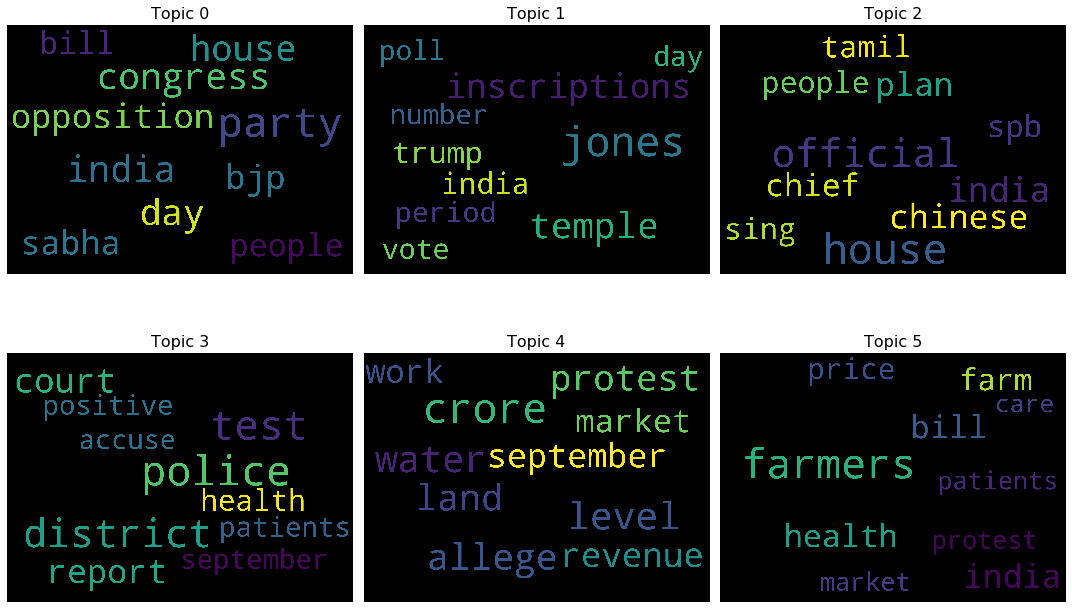

In [33]:
# Here I have made wordcloud for all the main keywords for each topic...
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='black',
                  width=2500,
                  height=1800,
                  max_words=10,
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(15,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

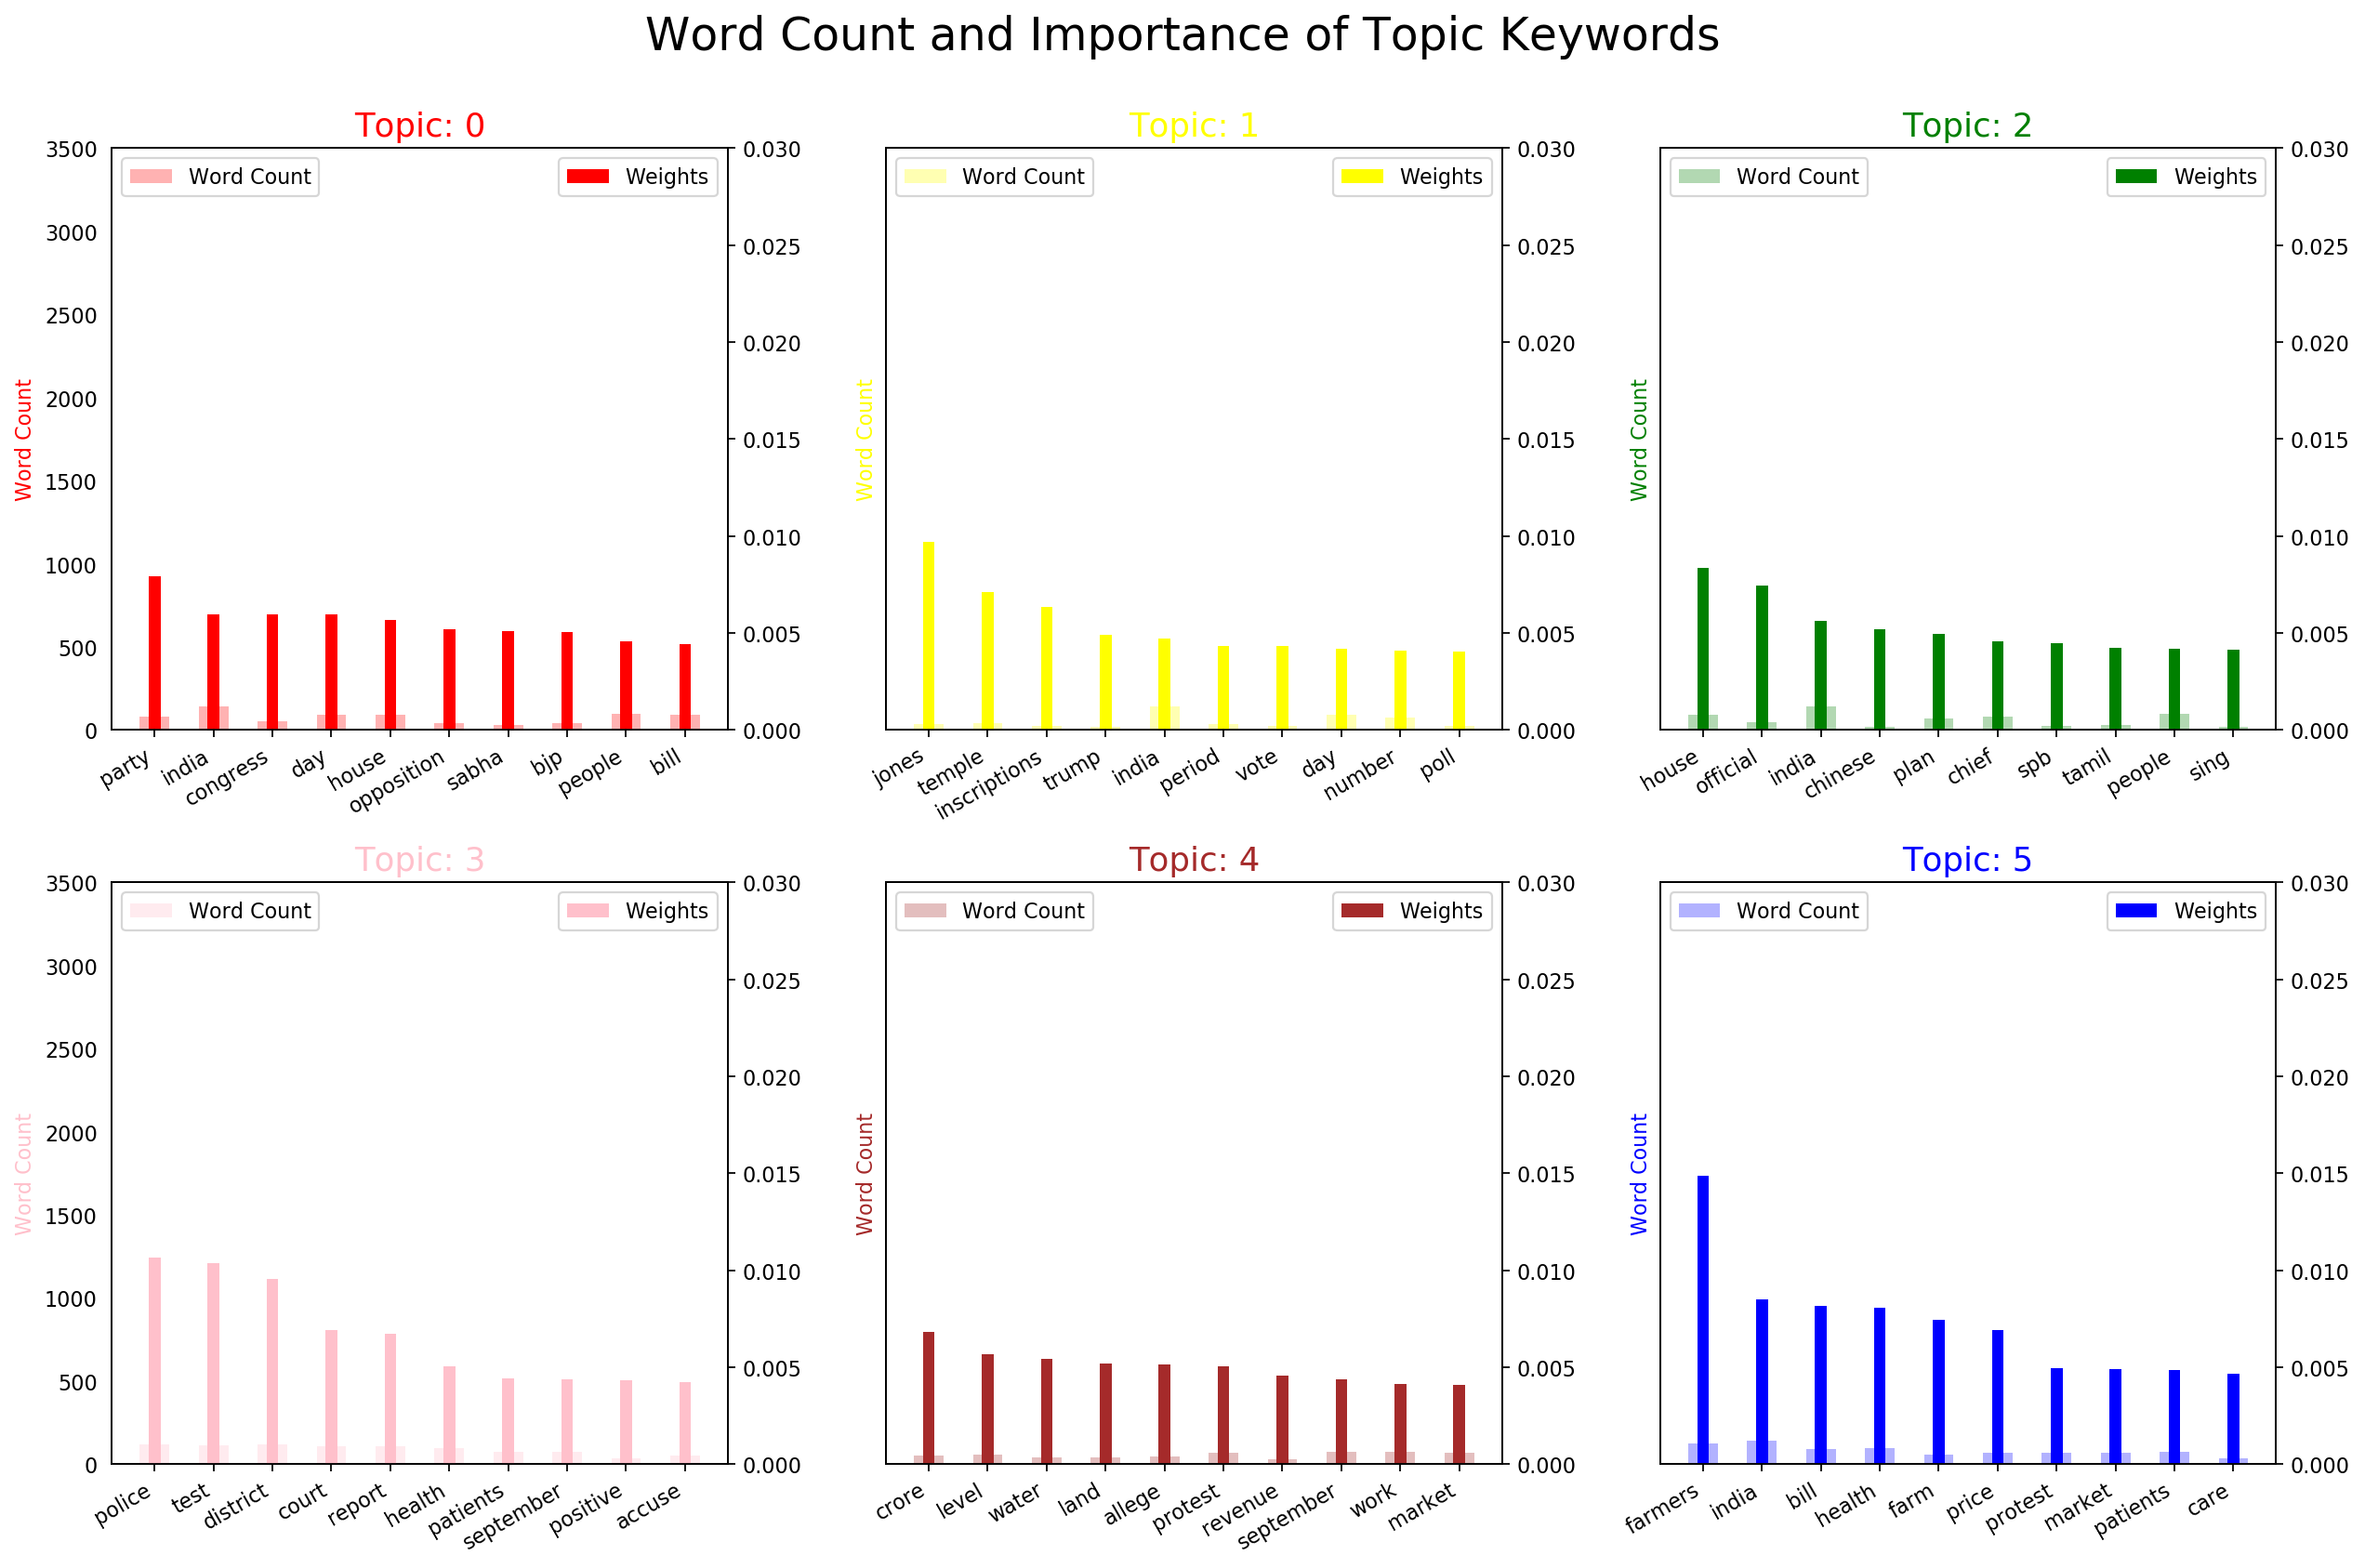

In [63]:
# using this code I am showing major keywords in a topic
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in Clean_data for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 3, figsize=(16,10), sharey=True, dpi=160)
cols=['red','yellow','green','pink','brown','blue']
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [34]:
#   Here I have displayed graphically all the topics , most 30 relevant keywords for the respective topic, 
#    You can easily visualize Each topic and its details more precisely and cleanly here.
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
vis

C:\Users\hp\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.040560  0.060484       1        1  25.761015
5      0.101297  0.031658       2        1  20.320412
0      0.035322 -0.146517       3        1  16.138775
4      0.060954  0.089642       4        1  15.434535
2      0.002267 -0.041224       5        1  12.149947
1     -0.159280  0.005958       6        1  10.195320, topic_info=     Category        Freq     Term       Total  loglift  logprob
1309  Default  115.000000  farmers  115.000000  30.0000  30.0000
1714  Default   29.000000    jones   29.000000  29.0000  29.0000
473   Default   89.000000   health   89.000000  28.0000  28.0000
159   Default  103.000000     test  103.000000  27.0000  27.0000
733   Default   37.000000   temple   37.000000  26.0000  26.0000
...       ...         ...      ...         ...      ...      ...
165    Topic6    8.365853   accord   45.589745   0.5877  -5.8460
213    Topic6    7.585455  present   21.081318   1.2611  -5.9440
159    Topic6    9.082076     test  103.746483  -0.1524  -5.7639
39     Topic6    8.101346     pass   39.033508   0.7109  -5.8782
176    Topic6    8.158829   centre   57.967316   0.3225  -5.8711

[419 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2585      3  0.173556  abraham
2585      4  0.781002  abraham
165       1  0.307087   accord
165       2  0.109674   accord
165       3  0.065804   accord
...     ...       ...      ...
2157      1  0.913865    zilla
949       1  0.053836     zone
949       2  0.053836     zone
949       4  0.807542     zone
949       6  0.107672     zone

[958 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 1, 5, 3, 2])

In [60]:
# Saving the list of  documents having most dominant topics..
df_dominant_topic.to_csv("Dominant_topic_list.csv")

In [50]:
# Cleaning test data using Processed_data function
k=Processed_data(docs_test)
num = 3
unseen_document = k[num]
print(unseen_document)

['total', 'people', 'test', 'positive', 'sars', 'cov', 'ernakulam', 'district', 'acquire', 'infection', 'locally', 'among', 'infect', 'nine', 'health', 'workers', 'include', 'asha', 'worker', 'many', 'persons', 'recover', 'illness', 'friday', 'people', 'bring', 'observation', 'home', 'district', 'people', 'observation', 'home', 'covid', 'care', 'centre', 'pay', 'quarantine', 'centre', 'district', 'saw', 'new', 'admissions', 'hospitals', 'first', 'line', 'treatment', 'centre', 'fltcs', 'friday', 'patients', 'discharge', 'district', 'friday', 'active', 'patients', 'recover', 'home', 'total', 'sample', 'send', 'district', 'test', 'friday', 'private', 'laboratories', 'hospitals', 'collect', 'sample', 'post', 'lift', 'operators', 'state', 'human', 'right', 'commission', 'shrc', 'order', 'make', 'available', 'service', 'lift', 'operators', 'government', 'medical', 'colleges', 'pronounce', 'order', 'case', 'nurse', 'assistant', 'get', 'stick', 'minutes', 'fall', 'unconscious', 'government', '

In [62]:
# Testing On the unseen data
bow_vector = dictionary.doc2bow(unseen_document)

for index, score in sorted(lda_model[bow_vector][0]):
    print("Score: {}\t Topic: {}\n".format(score, lda_model.print_topic(index, 30)))

Score: 0.05054537206888199	 Topic: 0.008*"party" + 0.006*"india" + 0.006*"congress" + 0.006*"day" + 0.006*"house" + 0.005*"opposition" + 0.005*"sabha" + 0.005*"bjp" + 0.005*"people" + 0.004*"bill" + 0.004*"chief" + 0.004*"tax" + 0.004*"rule" + 0.004*"confidence" + 0.004*"issue" + 0.004*"vodafone" + 0.004*"motion" + 0.004*"court" + 0.004*"price" + 0.004*"indian" + 0.004*"political" + 0.003*"business" + 0.003*"pass" + 0.003*"company" + 0.003*"come" + 0.003*"seat" + 0.003*"private" + 0.003*"bihar" + 0.003*"international" + 0.003*"lok"

Score: 0.0834164172410965	 Topic: 0.008*"house" + 0.007*"official" + 0.006*"india" + 0.005*"chinese" + 0.005*"plan" + 0.005*"chief" + 0.004*"spb" + 0.004*"tamil" + 0.004*"people" + 0.004*"sing" + 0.004*"bridge" + 0.004*"kannada" + 0.004*"senior" + 0.004*"room" + 0.004*"union" + 0.004*"bjp" + 0.003*"good" + 0.003*"space" + 0.003*"nadu" + 0.003*"rao" + 0.003*"agency" + 0.003*"project" + 0.003*"provide" + 0.003*"officials" + 0.003*"work" + 0.003*"lead" + 0.003